In [15]:
%matplotlib inline
import sys
import random
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import glob
import pandas as pd
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable, Kernel, AdvectionRK4

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from cartopy import crs, feature
import zarr 

sys.path.append('/ocean/vvalenzuela/MOAD/Ocean_Parcels')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [55]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/vvalenzuela/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc',
'out': '/home/vvalenzuela/MOAD/Ocean_Parcels/results/Mixing_Advection_Sinking',
'home': '/home/vvalenzuela/MOAD/analysis-vicente/Ocean_Parcels',
'anim': '/home/vvalenzuela/MOAD/Ocean_Parcels/animations'}

In [17]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [18]:
#Definitions
start = datetime(2023, 1, 1) #Start date
length = 30 # Set Time length [days] 

In [19]:
# function to get grid point gridX and gridY
path_NEMO = make_prefix(start,path['NEMO'])
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [20]:
fname_bio = []
fname_sal =[]
for i in range(0,length+1):
    fname_bio.append(make_prefix(start+timedelta(i),path['NEMO'])+'_biol_T.nc')
    fname_sal.append(make_prefix(start+timedelta(i),path['NEMO'])+'_grid_T.nc')    

From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$

Where:

- $[PBDE]_p$ represents the PBDEs concentration retained on the filter.

- $[PBDE]_{d,c}$ is the PBDEs concentrations pasing through the filter.

- $[POC]$ is the Particulate Organic Carbon.

We can use this parameter in Ocean Parcels for changing states between colloids and particuated PBDEs coming out of the pipe.


Option 1: Use the discharge data for PBDEs and use it with the POC data for a modified version of the equation above.

In [21]:
PBDE_data = pd.read_excel('/ocean/vvalenzuela/MOAD/analysis-vicente/PBDEs_DATA/predicted_discharges.xlsx')
time = PBDE_data['Unnamed: 0'].values
PBDE_data = PBDE_data.drop('Unnamed: 0', axis=1)
PBDE_data = PBDE_data.set_index(time)

In [22]:
hourly_discharge = pd.DataFrame(columns=['PBDE 28', 'PBDE 99', 'PBDE 209'])
for pbde in ['PBDE 28', 'PBDE 99', 'PBDE 209']:
    hourly_discharge[pbde] = pd.to_numeric(PBDE_data[pbde], errors='coerce').resample("1h").interpolate("linear")

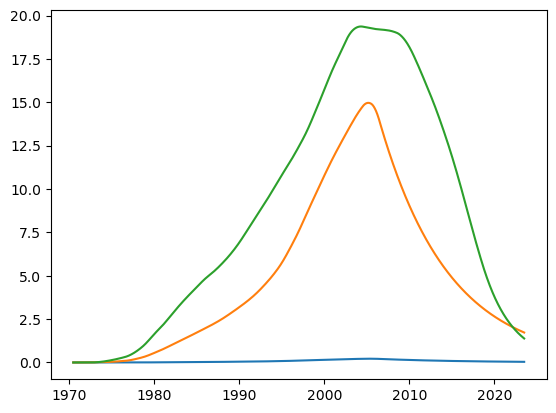

In [23]:
plt.plot(hourly_discharge)

In [24]:
bio = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01aug22/SalishSea_1h_20220801_20220801_biol_T.nc')
var = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01aug22/SalishSea_1h_20220801_20220801_grid_T.nc')

In [25]:
jjii = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc')
def finder(lati,loni):
    j = [jjii.jj.sel(lats=lati, lons=loni, method='nearest').item()][0]
    i = [jjii.ii.sel(lats=lati, lons=loni, method='nearest').item()][0]
    return j,i

In [12]:
clat = [49.2]
clon = [-123.4]
#
a, b = finder(clat[0], clon[0])

In [13]:
depth = bio.deptht.values

In [14]:
dd = 0
dd1 = 9 
dd2 = 26
poc = []
doc = []
sal = []
poc1 = []
doc1 = []
sal1 = []
poc2 = []
doc2 = []
sal2 = []
for i in range(length+1):
    bio_data = xr.open_dataset(fname_bio[i])
    sal_data = xr.open_dataset(fname_sal[i])
    #
    poc_data = ((bio_data['particulate_organic_nitrogen'][:,dd,a,b]*(16/106)).values)
    doc_data = ((bio_data['dissolved_organic_nitrogen'][:,dd,a,b]*(16/106)).values)
    sali_data = ((sal_data['vosaline'][:,dd,a,b]).values)
    #
    poc_data1 = ((bio_data['particulate_organic_nitrogen'][:,dd1,a,b]*(16/106)).values)
    doc_data1 = ((bio_data['dissolved_organic_nitrogen'][:,dd1,a,b]*(16/106)).values)
    sali_data1 = ((sal_data['vosaline'][:,dd1,a,b]).values)
    #
    poc_data2 = ((bio_data['particulate_organic_nitrogen'][:,dd2,a,b]*(16/106)).values)
    doc_data2 = ((bio_data['dissolved_organic_nitrogen'][:,dd2,a,b]*(16/106)).values)
    sali_data2 = ((sal_data['vosaline'][:,dd2,a,b]).values)
    #
    poc.append(poc_data)
    doc.append(doc_data)
    sal.append(sali_data)
    #
    poc1.append(poc_data1)
    doc1.append(doc_data1)
    sal1.append(sali_data1)    
    #
    poc2.append(poc_data2)
    doc2.append(doc_data2)
    sal2.append(sali_data2)
#
poc_array = np.concatenate(poc)
doc_array = np.concatenate(doc)
sal_array = np.concatenate(sal)
#
poc_array1 = np.concatenate(poc1)
doc_array1 = np.concatenate(doc1)
sal_array1 = np.concatenate(sal1)
#
poc_array2 = np.concatenate(poc2)
doc_array2 = np.concatenate(doc2)
sal_array2 = np.concatenate(sal2)


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
#
blevels = list(np.arange(0,500,100))
#
im=ax.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
ax.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
ax.scatter(clon[0],clat[0],zorder=3,marker='*',c='r',s=50)
#
ax.set_ylim([clat[0]-.5,clat[0]+.5])
ax.set_xlim([clon[0]-.5,clon[0]+.5])
#
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.8)
cbar.set_label('Depth [m]')

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(poc_array, 'k', label = 'POC')
ax[0].plot(doc_array, 'g', label = 'DOC')
ax[0].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')
#
ax1=ax[0].twinx()
#
ax1.plot(sal_array, 'r', label = 'Salinty')
ax1.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[0].legend(loc = 'upper left')
ax1.legend(loc = 'upper right')
#
ax[0].set_title('Time Series at ' + str(depth[dd]) + ' m depth')
########
ax[1].plot(poc_array1, 'k', label = 'POC')
ax[1].plot(doc_array1, 'g', label = 'DOC')
ax[1].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')

#
ax2=ax[1].twinx()
#
ax2.plot(sal_array1, 'r', label = 'Salinty')
ax2.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[1].legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
#
ax[1].set_title('Time Series at ' + str(depth[dd1]) + ' m depth')

##########
ax[2].plot(poc_array2, 'k', label = 'POC')
ax[2].plot(doc_array2, 'g', label = 'DOC')
ax[2].set_ylabel(r'POC and DOC [$mmol \cdot m^{-3}$]')

#
ax3=ax[2].twinx()
#
ax3.plot(sal_array2, 'r', label = 'Salinty')
ax3.set_ylabel(r'Salinity [$g \cdot kg^{-1}$]')
#
ax[2].legend(loc = 'upper left')
ax3.legend(loc = 'upper right')
#
ax[2].set_xlabel('Time Counts')
ax[2].set_title('Time Series at ' + str(depth[dd2]) + ' m depth')
#
plt.tight_layout()


In [ ]:
(bio['particulate_organic_nitrogen'][:,0,a,b]*(16/106)).plot()

In [ ]:
t = 10
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(bio['particulate_organic_nitrogen'][t,:,a,b]*(16/106), bio['particulate_organic_nitrogen'].deptht,'--g', label = r'POC $[mmol \cdot m^{-3}]$')
ax.plot(bio['dissolved_organic_nitrogen'][t,:,a,b]*(16/106), bio['particulate_organic_nitrogen'].deptht,'g', label = r'DOC $[mmol \cdot m^{-3}]$')
ax.tick_params(axis="x", labelcolor='g')
ax.legend(loc='lower right')
#
ax1=ax.twiny()
ax1.plot(var['vosaline'][t,:,a,b], var['vosaline'].deptht,'r', label = r'Salinity [g/kg]')
ax1.tick_params(axis="x", labelcolor='r')
ax1.legend(loc='lower left')
#
ax.grid(linestyle = '--')
ax.set_ylim(0,150)
ax.set_ylabel('Depth [m]')


plt.gca().invert_yaxis()


In [ ]:
POC = bio['particulate_organic_nitrogen']*(16/106)
DOC = bio['dissolved_organic_nitrogen']*(16/106)
coords = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/ocean/vvalenzuela/MOAD/grid2/mesh_mask202108_TDV.nc')

In [ ]:
poc_mean = np.mean(bio['particulate_organic_nitrogen'][:,:,:,:]*(16/106), axis=1)
doc_mean = np.mean(bio['dissolved_organic_nitrogen'][:,:,:,:]*(16/106), axis=1)

In [ ]:
ParcelsRandom.random()

$$\textbf{From here working with monthly data to get POC values}$$

Here the idea is to create a POC parameter from the SalishSeaCast model output. The monthly data is for making it easier to work with. Different regions are going to be extracted for further analysis and final decisions of an "accurate" POC value.


After this analysis, the idea is to use thi value for differenciating the PBDEs phases between Colloidal and Particulate forms.


In [26]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [27]:
path_months = '/results2/SalishSea/month-avg.202111/'

In [28]:
def monthly_prefix(date, path, area='biol_T_'):
    #
    prefix = os.path.join(path, f'SalishSeaCast_1m_{area}{date.strftime("%Y%m%d").lower()}*')
    file_name = glob.glob(prefix) 
    #
    return file_name

In [29]:
def month_year_bio_data(model_year_datetime):
    fname_bio_monthly = []
    months = 12
    for i in range(1,months+1):
        fname_bio_monthly.append(monthly_prefix(model_year_datetime+relativedelta(month=i),path_months, area='biol_T_'))
    #
    return fname_bio_monthly 

Here I want to extract different regions from the Salish Sea to compare POC values and create the new "changing phase value"

In [30]:
def poc_data(bio_dataset):
    #
    poc = xr.open_dataset(bio_dataset)['particulate_organic_nitrogen']*(16/106)
    poc = poc.where(poc != 0, np.nan)
    #
    if (poc.dims[0] == 'time_counter') or (poc.dims[1] == 'deptht') or (poc.dims[2] == 'y') or (poc.dims[3] == 'x'):
        poc = poc.rename({'x' : 'gridX', 'y' : 'gridY', 'deptht' : 'depth', 'time_counter' : 'gridX'})
    else:
        poc = xr.open_dataset(bio_dataset)['particulate_organic_nitrogen']*(16/106)
        poc = poc.where(poc != 0, np.nan)
   
    box_gridX = [[110, 250], [150, 350], [280, 370]]
    box_gridY = [[560, 730], [400, 560], [310, 400]]
    #
    #### Take slices of data for the three different regions:
    NSoG = poc.isel(gridY=slice(box_gridY[0][0],box_gridY[0][1]), gridX=slice(box_gridX[0][0],box_gridX[0][1]))
    CSoG = poc.isel(gridY=slice(box_gridY[1][0],box_gridY[1][1]), gridX=slice(box_gridX[1][0],box_gridX[1][1]))
    SSoG = poc.isel(gridY=slice(box_gridY[2][0],box_gridY[2][1]), gridX=slice(box_gridX[2][0],box_gridX[2][1]))
    #
    return NSoG, CSoG, SSoG

In [31]:
NSoG, CSoG, SSoG = poc_data(month_year_bio_data(datetime(2023,1,1))[0][0])

Plotting for looking at how it's changing in depth for one averaged month

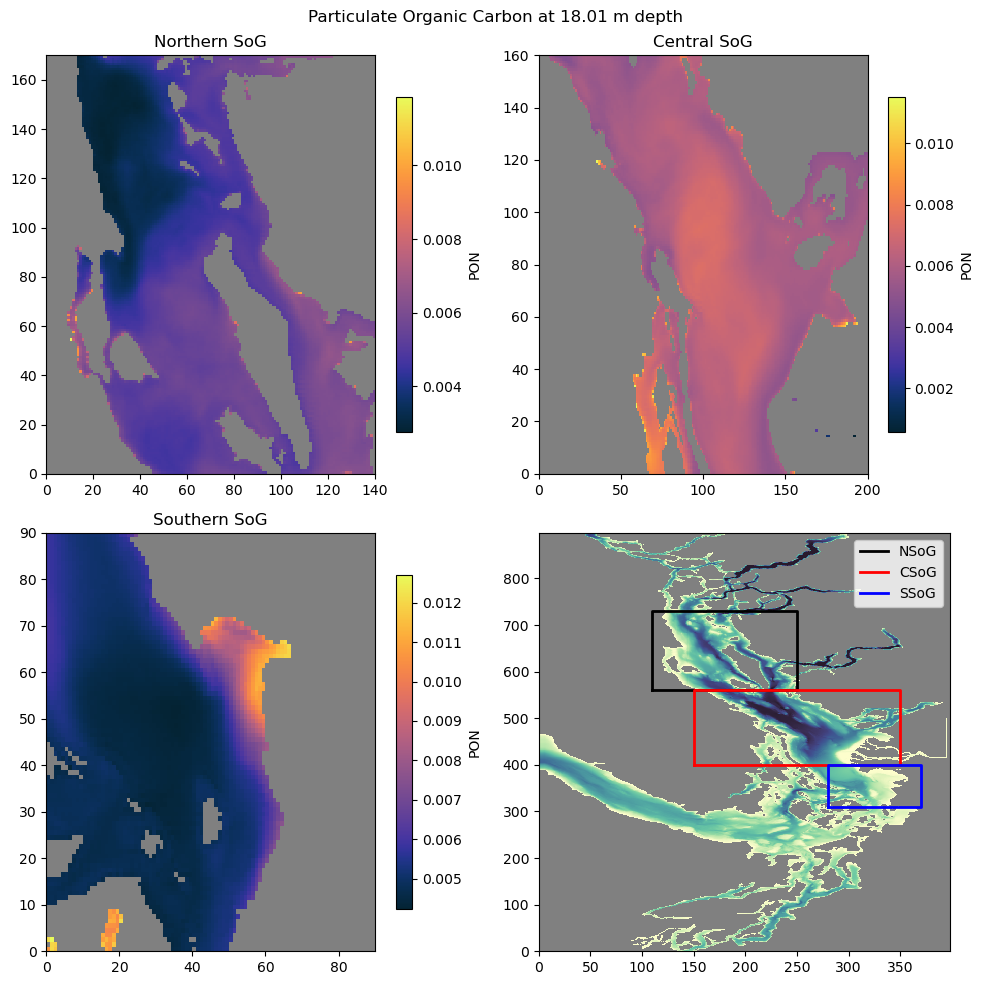

In [32]:
bathymetry = xr.open_dataset(path['bat']).Bathymetry
dd = 17
cmap_poc = cmocean.cm.thermal
cmap_poc.set_bad('grey')
cmap.set_bad('grey')
#
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG[0,dd,:,:], cmap=cmap_poc)
central = ax[0,1].pcolormesh(CSoG[0,dd,:,:], cmap=cmap_poc)
south = ax[1,0].pcolormesh(SSoG[0,dd,:,:], cmap=cmap_poc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('PON')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('PON')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('PON')
#
plt.suptitle('Particulate Organic Carbon at ' + str(np.round(NSoG.depth.values[dd], 2)) + ' m depth')
#
plt.tight_layout()


Lets calculate the depth mean for each one of these regions:

In [33]:
NSoG_mean = np.mean(NSoG[0,:,:,:], axis=0)
CSoG_mean = np.mean(CSoG[0,:,:,:], axis=0)
SSoG_mean = np.mean(SSoG[0,:,:,:], axis=0)

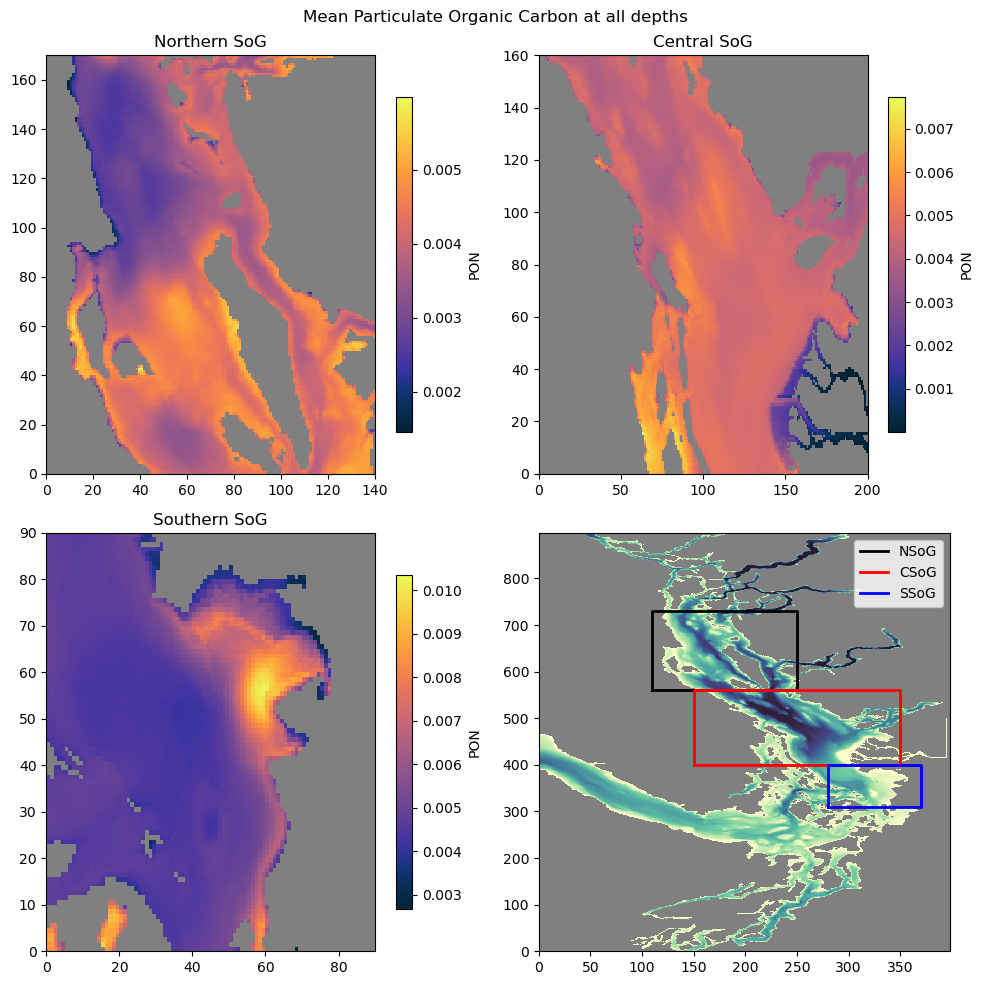

In [34]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
north = ax[0,0].pcolormesh(NSoG_mean, cmap=cmap_poc)
central = ax[0,1].pcolormesh(CSoG_mean, cmap=cmap_poc)
south = ax[1,0].pcolormesh(SSoG_mean, cmap=cmap_poc)
#
ax[1,1].pcolormesh(bathymetry, cmap=cmap)
ax[1,1].plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
ax[1,1].plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
ax[1,1].plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
ax[1,1].legend()
#
ax[0,0].set_title('Northern SoG')
ax[0,1].set_title('Central SoG')
ax[1,0].set_title('Southern SoG')
#
cbar = fig.colorbar(north, ax=ax[0,0], location='right', shrink=0.8)
cbar.set_label('PON')
#
cbar1 = fig.colorbar(central, ax=ax[0,1], location='right', shrink=0.8)
cbar1.set_label('PON')
#
cbar2 = fig.colorbar(south, ax=ax[1,0], location='right', shrink=0.8)
cbar2.set_label('PON')
#
plt.suptitle('Mean Particulate Organic Carbon at all depths')
#
plt.tight_layout()

Now, lets calculate the mean for all the regions, having just a single values for each one of them:

In [35]:
POC_NSoG = np.mean(NSoG_mean).values
POC_CSoG = np.mean(CSoG_mean).values
POC_SSoG = np.mean(SSoG_mean).values

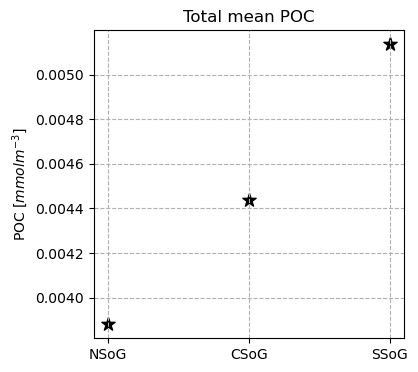

In [36]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(['NSoG','CSoG','SSoG'], [POC_NSoG, POC_CSoG, POC_SSoG], c = 'k', marker = '*', s=100)
ax.set_ylabel(r'POC [$mmol m^{-3}$]')
ax.set_title('Total mean POC')
ax.grid(linestyle = '--')

Now, lets see how this 'total mean POC' changes through the year:

In [37]:
POC_NSoG_year = []
POC_CSoG_year = []
POC_SSoG_year = []
for i in range(0, 12):
    NSoG_year, CSoG_year, SSoG_year = poc_data(month_year_bio_data(datetime(2023,1,1))[i][0])
    #
    POC_NSoG_year.append(np.mean(NSoG_year[0,:,:,:]))
    POC_CSoG_year.append(np.mean(CSoG_year[0,:,:,:]))
    POC_SSoG_year.append(np.mean(SSoG_year[0,:,:,:]))        

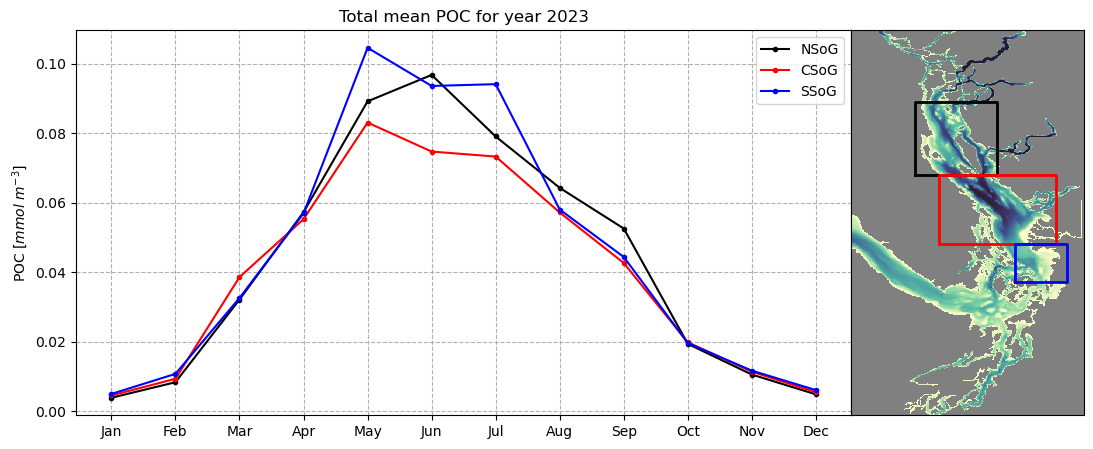

In [38]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(meses, POC_NSoG_year, '.-k', label = 'NSoG')
ax.plot(meses, POC_CSoG_year, '.-r', label = 'CSoG')
ax.plot(meses, POC_SSoG_year, '.-b', label = 'SSoG')
ax.legend(loc = 'upper right')
ax.set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax.set_title('Total mean POC for year 2023')
ax.grid(linestyle = '--')
##### Small map for regions reference
#
axins = ax.inset_axes([1, 0, 0.3, 1])
#
prof = axins.pcolormesh(bathymetry, cmap=cmap)
axins.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)



Now, for all the years in the Salish Sea Cast Model:

In [39]:
years_ssc = np.arange(2007, 2024, 1)

In [40]:
# Create pandas dataframes for easier manipulation an visualization of the data
POC_NSoG_all = pd.DataFrame(columns = years_ssc, index = meses)
POC_CSoG_all = pd.DataFrame(columns = years_ssc, index = meses)
POC_SSoG_all = pd.DataFrame(columns = years_ssc, index = meses)

In [41]:
for year in years_ssc:
    for i in range(0, 12):
        NSoG_month, CSoG_month, SSoG_month = poc_data(month_year_bio_data(datetime(year,1,1))[i][0])
        #
        POC_NSoG_all[year][i] = np.mean(NSoG_month).values
        POC_CSoG_all[year][i] = np.mean(CSoG_month).values
        POC_SSoG_all[year][i] = np.mean(SSoG_month).values           

In [42]:
POC_NSoG_all[2008]['Jun'] = (POC_NSoG_all[2008]['May'] + POC_NSoG_all[2008]['Jul'])/2
POC_CSoG_all[2008]['Jun'] = (POC_CSoG_all[2008]['May'] + POC_CSoG_all[2008]['Jul'])/2
POC_SSoG_all[2008]['Jun'] = (POC_SSoG_all[2008]['May'] + POC_SSoG_all[2008]['Jul'])/2

Plot for all years in the different parts of the SoG:

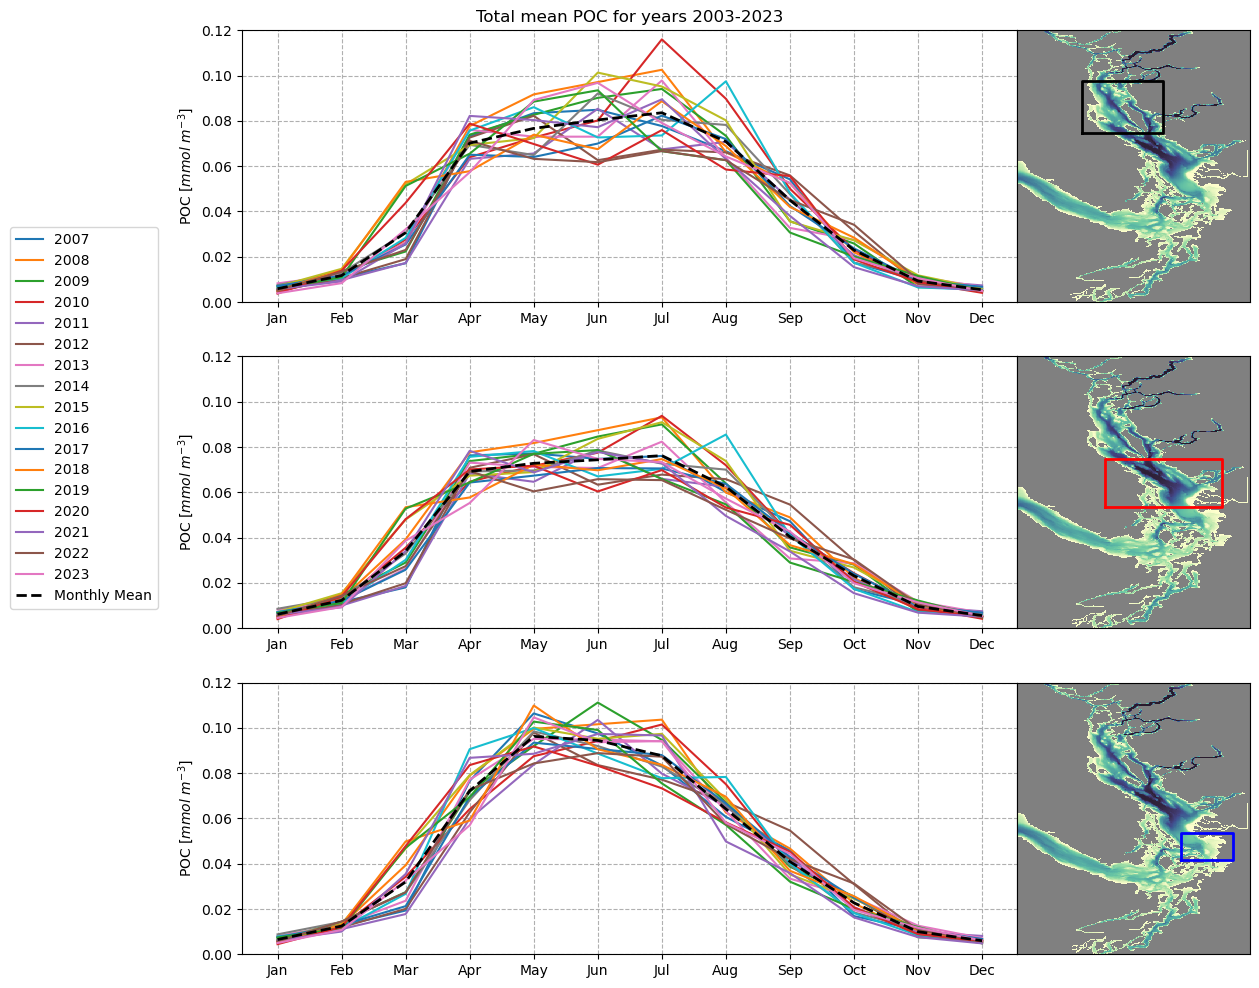

In [43]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, ax = plt.subplots(3,1,figsize=(10,12))
ax[0].plot(POC_NSoG_all.index, POC_NSoG_all, label = years_ssc)
ax[0].plot(POC_CSoG_all.index, POC_NSoG_all.mean(axis=1), '--k', linewidth=2, label='Monthly Mean')
ax[0].legend(loc = 'upper right', bbox_to_anchor=(-0.1, 0.3))
ax[0].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[0].set_title('Total mean POC for years 2003-2023')
ax[0].grid(linestyle = '--')
ax[0].set_ylim(0,0.12)
#
ax[1].plot(POC_CSoG_all.index, POC_CSoG_all)
ax[1].plot(POC_CSoG_all.index, POC_CSoG_all.mean(axis=1), '--k', linewidth=2)
ax[1].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[1].grid(linestyle = '--')
ax[1].set_ylim(0,0.12)
#
ax[2].plot(POC_SSoG_all.index, POC_SSoG_all)
ax[2].plot(POC_CSoG_all.index, POC_SSoG_all.mean(axis=1), '--k', linewidth=2)
ax[2].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[2].grid(linestyle = '--')
ax[2].set_ylim(0,0.12)
#
#
axins0 = ax[0].inset_axes([1, 0, 0.3, 1])
axins0.pcolormesh(bathymetry, cmap=cmap)
axins0.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins0.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
#
axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
axins1.pcolormesh(bathymetry, cmap=cmap)
axins1.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
#
#
axins2 = ax[2].inset_axes([1, 0, 0.3, 1])
axins2.pcolormesh(bathymetry, cmap=cmap)
axins2.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
axins2.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)



Text(0.5, 1.0, 'Ratio between POC and Mean POC ($POC/POC_{mean}$)')

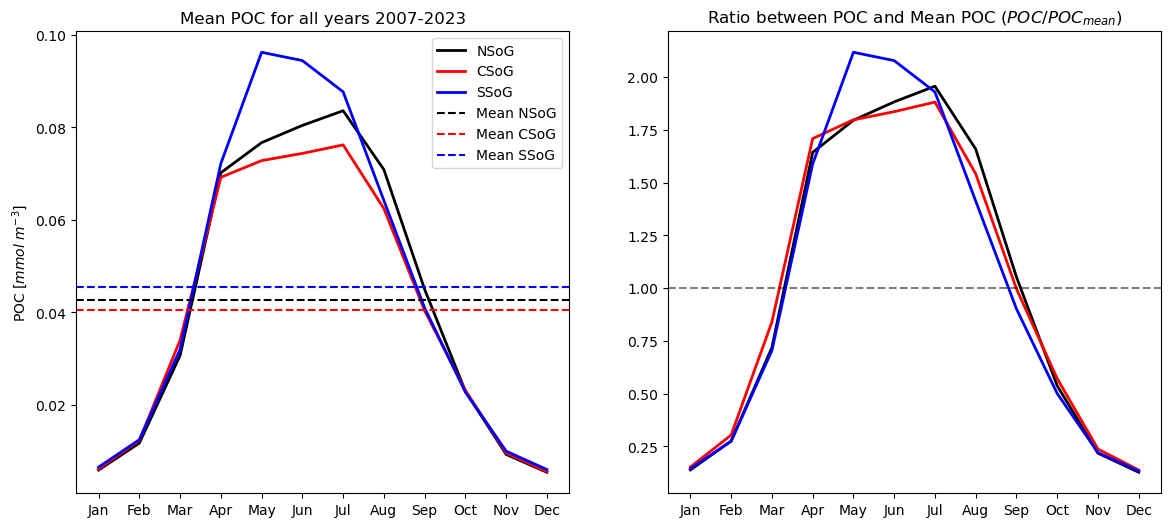

In [44]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].plot(POC_NSoG_all.index, POC_NSoG_all.mean(axis=1), '-k', linewidth=2, label='NSoG')
ax[0].plot(POC_CSoG_all.index, POC_CSoG_all.mean(axis=1), '-r', linewidth=2, label='CSoG')
ax[0].plot(POC_SSoG_all.index, POC_SSoG_all.mean(axis=1), '-b', linewidth=2, label='SSoG')
#
ax[0].axhline(y=np.mean(POC_NSoG_all.mean(axis=1)), color = 'k', linestyle = '--', label = 'Mean NSoG')
ax[0].axhline(y=np.mean(POC_CSoG_all.mean(axis=1)), color = 'r', linestyle = '--', label = 'Mean CSoG')
ax[0].axhline(y=np.mean(POC_SSoG_all.mean(axis=1)), color = 'b', linestyle = '--', label = 'Mean SSoG')
#
ax[0].set_ylabel(r'POC [$mmol\ m^{-3}$]')
#
ax[0].legend()
#
ax[0].set_title('Mean POC for all years 2007-2023')
#
#
ax[1].plot(POC_NSoG_all.index, POC_NSoG_all.mean(axis=1)/np.mean(POC_NSoG_all.mean(axis=1)), '-k', linewidth=2, label='NSoG')
ax[1].plot(POC_CSoG_all.index, POC_CSoG_all.mean(axis=1)/np.mean(POC_CSoG_all.mean(axis=1)), '-r', linewidth=2, label='CSoG')
ax[1].plot(POC_SSoG_all.index, POC_SSoG_all.mean(axis=1)/np.mean(POC_SSoG_all.mean(axis=1)), '-b', linewidth=2, label='SSoG')
ax[1].axhline(y=1, color = 'k', linestyle = '--', alpha = 0.5)
ax[1].set_title(r'Ratio between POC and Mean POC ($POC/POC_{mean}$)')

#

In [45]:
print('Mean POC Value for NSoG: ' + str(np.mean(POC_NSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
print('Mean POC Value for CSoG: ' + str(np.mean(POC_CSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
print('Mean POC Value for SSoG: ' + str(np.mean(POC_SSoG_all.mean(axis=1))) + ' in $mmol m^{-3}$')
seasonal_mean_NSoG_all = np.mean(POC_NSoG_all.mean(axis=1))
seasonal_mean_CSoG_all = np.mean(POC_CSoG_all.mean(axis=1))
seasonal_mean_SSoG_all = np.mean(POC_SSoG_all.mean(axis=1))

Mean POC Value for NSoG: 0.04270812763156844 in $mmol m^{-3}$
Mean POC Value for CSoG: 0.04049420431621519 in $mmol m^{-3}$
Mean POC Value for SSoG: 0.0454328345755736 in $mmol m^{-3}$


In [46]:
print('Mean POC Value for NSoG: ' + str(np.mean(POC_NSoG_all.mean(axis=1))*(12.0107*10**(-3))) + ' in $Kg / L$')
print('Mean POC Value for CSoG: ' + str(np.mean(POC_CSoG_all.mean(axis=1))*(12.0107*10**(-3))) + ' in $Kg / L$')
print('Mean POC Value for SSoG: ' + str(np.mean(POC_SSoG_all.mean(axis=1))*(12.0107*10**(-3))) + ' in $Kg / L$')

Mean POC Value for NSoG: 0.0005129545085444791 in $Kg / L$
Mean POC Value for CSoG: 0.00048636373978076585 in $Kg / L$
Mean POC Value for SSoG: 0.0005456801462368419 in $Kg / L$


Table of mean POC values per region:


|| Northern Strait of Georgia | Central Strait of Georgia | Sothern Strait of Georgia |
|--------------------------| -------------------------- | ------------------------- | ------------------------- |
| $\textbf{POC}$ $[mmol m^{-3}]$ | $\textbf{0.04270812763156844}$ |  $\textbf{0.04049420431621519}$ |  $\textbf{0.0454328345755736}$ |
| $\textbf{POC}$ $[Kg / L]$ | $\textbf{0.0005129545085444791}$ |  $\textbf{0.00048636373978076585}$ |  $\textbf{0.0005456801462368419}$ |



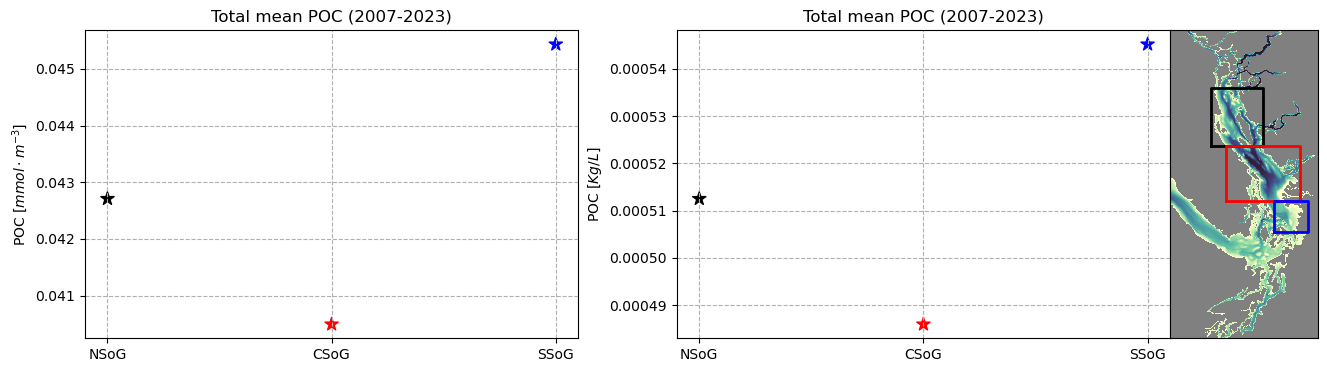

In [47]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].scatter(['NSoG','CSoG','SSoG'], [seasonal_mean_NSoG_all, seasonal_mean_CSoG_all, seasonal_mean_SSoG_all], c = ['k','r','b'], marker = '*', s=100)
ax[0].set_ylabel(r'POC [$mmol \cdot m^{-3}$]')
ax[0].set_title('Total mean POC (2007-2023)')
ax[0].grid(linestyle = '--')
#
ax[1].scatter(['NSoG','CSoG','SSoG'], [seasonal_mean_NSoG_all*(12*10**(-3)), seasonal_mean_CSoG_all*(12*10**(-3)), seasonal_mean_SSoG_all*(12*10**(-3))], c = ['k','r','b'], marker = '*', s=100)
ax[1].set_ylabel(r'POC [$Kg/L$]')
ax[1].set_title('Total mean POC (2007-2023)')
ax[1].grid(linestyle = '--')
#
axins = ax[1].inset_axes([1, 0, 0.3, 1])
#
prof = axins.pcolormesh(bathymetry, cmap=cmap)
axins.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
axins.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
axins.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
#
axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)


Lets check our equation again:


From Sun et al. 2023 we obtain a partitioning relation of PBDEs between dissolved and particulate states:



$K_{oc,a} = [PBDE]_p / ([PBDE]_{d,c} \cdot [POC])$


Assuming that $K_{oc,a}$ is a constant, then we can get the following relation for POC:

$[POC] = \frac{[PBDE]_p}{[PBDE]_{d,c}} \cdot \frac{1}{K_{oc,a}}$


So, 


- IF $[POC]$ is HIGH $\Rightarrow$ HIGH $[PBDE]_p$ is expected 

- IF $[POC]$ is LOW $\Rightarrow$ HIGH $[PBDE]_{d,c}$ is expected 



Now, letk look at the differences between POC values and the background POC concentrations

In [48]:
NSoG_mean_seasonal = POC_NSoG_all.mean(axis=1)
CSoG_mean_seasonal = POC_CSoG_all.mean(axis=1)
SSoG_mean_seasonal = POC_SSoG_all.mean(axis=1)


In [56]:
for i in range(0,len(years_ssc)):
    fig, ax = plt.subplots(3,2,figsize=(14,10))
    #
    diff_NSoG = np.array((POC_NSoG_all[years_ssc[i]].astype(float).values - NSoG_mean_seasonal.astype(float).values))
    ax[0,0].plot(POC_NSoG_all.index, POC_NSoG_all[years_ssc[i]], '-k', label = str(years_ssc[i]))
    ax[0,0].plot(POC_NSoG_all.index, NSoG_mean_seasonal, '--k', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[0,0].set_ylabel(r'NSoG POC [$mmol\ m^{-3}$]')
    ax[0,0].legend(loc = 'upper right')
    ax[0,0].set_title(str(years_ssc[i]) + r' mean and total years mean')
    ax[0,0].grid(linestyle = '--')
    ax[0,0].set_ylim(0,0.06)
    #
    ax[0,1].fill_between(meses, diff_NSoG ,0 , where=(diff_NSoG >= 0), interpolate=True, color='green', alpha=1, label = 'POC above total mean')
    ax[0,1].fill_between(meses, diff_NSoG ,0 , where=(diff_NSoG < 0), interpolate=True, color='green', alpha=0.5, label = 'POC below total mean')
    ax[0,1].plot(meses, diff_NSoG, 'k', alpha = 0.5)
    ax[0,1].set_ylim(-0.02, 0.02)
    ax[0,1].legend()
    ax[0,1].grid(linestyle = '--')
    ax[0,1].set_title(str(years_ssc[i]) + r' mean and total years mean difference')
    #
    axins0 = ax[0,1].inset_axes([1, 0, 0.3, 1])
    axins0.pcolormesh(bathymetry, cmap=cmap)
    axins0.plot([110, 110, 250, 250, 110],[560, 730, 730, 560, 560], '-k', linewidth = 2, label='NSoG')
    axins0.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################
    diff_CSoG = np.array((POC_CSoG_all[years_ssc[i]].astype(float).values - CSoG_mean_seasonal.astype(float).values))
    ax[1,0].plot(POC_CSoG_all.index, POC_CSoG_all[years_ssc[i]], '-r', label = str(years_ssc[i]))
    ax[1,0].plot(POC_CSoG_all.index, CSoG_mean_seasonal, '--r', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[1,0].set_ylabel(r'CSoG POC [$mmol\ m^{-3}$]')
    ax[1,0].legend(loc = 'upper right')
    ax[1,0].grid(linestyle = '--')
    ax[1,0].set_ylim(0,0.06)
    #
    ax[1,1].fill_between(meses, diff_CSoG ,0 , where=(diff_CSoG >= 0), interpolate=True, color='green', alpha=1, label = 'POC above total mean')
    ax[1,1].fill_between(meses, diff_CSoG ,0 , where=(diff_CSoG < 0), interpolate=True, color='green', alpha=0.5, label = 'POC below total mean')
    ax[1,1].plot(meses, diff_CSoG, 'k', alpha = 0.5)
    ax[1,1].set_ylim(-0.02, 0.02)
    ax[1,1].legend()
    ax[1,1].grid(linestyle = '--')
    #
    axins1 = ax[1,1].inset_axes([1, 0, 0.3, 1])
    axins1.pcolormesh(bathymetry, cmap=cmap)
    axins1.plot([150, 150, 350, 350, 150],[400, 560, 560, 400, 400], '-r', linewidth = 2, label='CSoG')
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################
    diff_SSoG = np.array((POC_SSoG_all[years_ssc[i]].astype(float).values - SSoG_mean_seasonal.astype(float).values))
    ax[2,0].plot(POC_SSoG_all.index, POC_SSoG_all[years_ssc[i]], '-b', label = str(years_ssc[i]))
    ax[2,0].plot(POC_SSoG_all.index, SSoG_mean_seasonal, '--b', linewidth=2, alpha = 0.5, label='Total Mean')
    ax[2,0].set_ylabel(r'SSoG POC [$mmol\ m^{-3}$]')
    ax[2,0].legend(loc = 'upper right')
    ax[2,0].grid(linestyle = '--')
    ax[2,0].set_ylim(0,0.06)
    #
    ax[2,1].fill_between(meses, diff_SSoG ,0 , where=(diff_SSoG >= 0), interpolate=True, color='green', alpha=1, label = 'POC above total mean')
    ax[2,1].fill_between(meses, diff_SSoG ,0 , where=(diff_SSoG < 0), interpolate=True, color='green', alpha=0.5, label = 'POC below total mean')
    ax[2,1].plot(meses, diff_SSoG, 'k', alpha = 0.5)
    ax[2,1].set_ylim(-0.02, 0.02)
    ax[2,1].legend()
    ax[2,1].grid(linestyle = '--')
    #
    axins2 = ax[2,1].inset_axes([1, 0, 0.3, 1])
    axins2.pcolormesh(bathymetry, cmap=cmap)
    axins2.plot([280, 280, 370, 370, 280],[310, 400, 400, 310, 310], '-b', linewidth = 2, label='SSoG')
    axins2.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()
    #
    path1 = os.path.join(r'/home/vvalenzuela/MOAD/POC/POC_years_plots')
    file = os.path.join(path1, str(years_ssc[i]) + '_POC_mean_and_diff.png')
    plt.savefig(file)    
    #
    plt.close()


Lets now check some statistics:

- See how each year POC is compared to the mean values calculated before

In [50]:
quartiles_POC_NSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)
quartiles_POC_CSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)
quartiles_POC_SSoG = pd.DataFrame(index= ['Q1', 'Q2', 'Q3'], columns=years_ssc)

In [51]:
for i in years_ssc:
    quartiles_POC_NSoG[i] = POC_NSoG_all[i].quantile([0.25, 0.5, 0.75]).values
    quartiles_POC_CSoG[i] = POC_CSoG_all[i].quantile([0.25, 0.5, 0.75]).values
    quartiles_POC_SSoG[i] = POC_SSoG_all[i].quantile([0.25, 0.5, 0.75]).values

In [52]:
max_poc_NSoG = []
min_poc_NSoG = []
max_poc_CSoG = []
min_poc_CSoG = []
max_poc_SSoG = []
min_poc_SSoG = []
#
mean_poc_NSoG = []
mean_poc_CSoG = []
mean_poc_SSoG = []
#
for y in years_ssc:
    max_poc_NSoG.append(POC_NSoG_all[y].max())
    min_poc_NSoG.append(POC_NSoG_all[y].min())
    max_poc_CSoG.append(POC_CSoG_all[y].max())
    min_poc_CSoG.append(POC_CSoG_all[y].min()) 
    max_poc_SSoG.append(POC_SSoG_all[y].max())
    min_poc_SSoG.append(POC_SSoG_all[y].min())    
    mean_poc_NSoG.append(POC_NSoG_all[y].mean()) 
    mean_poc_CSoG.append(POC_CSoG_all[y].mean())
    mean_poc_SSoG.append(POC_SSoG_all[y].mean())      

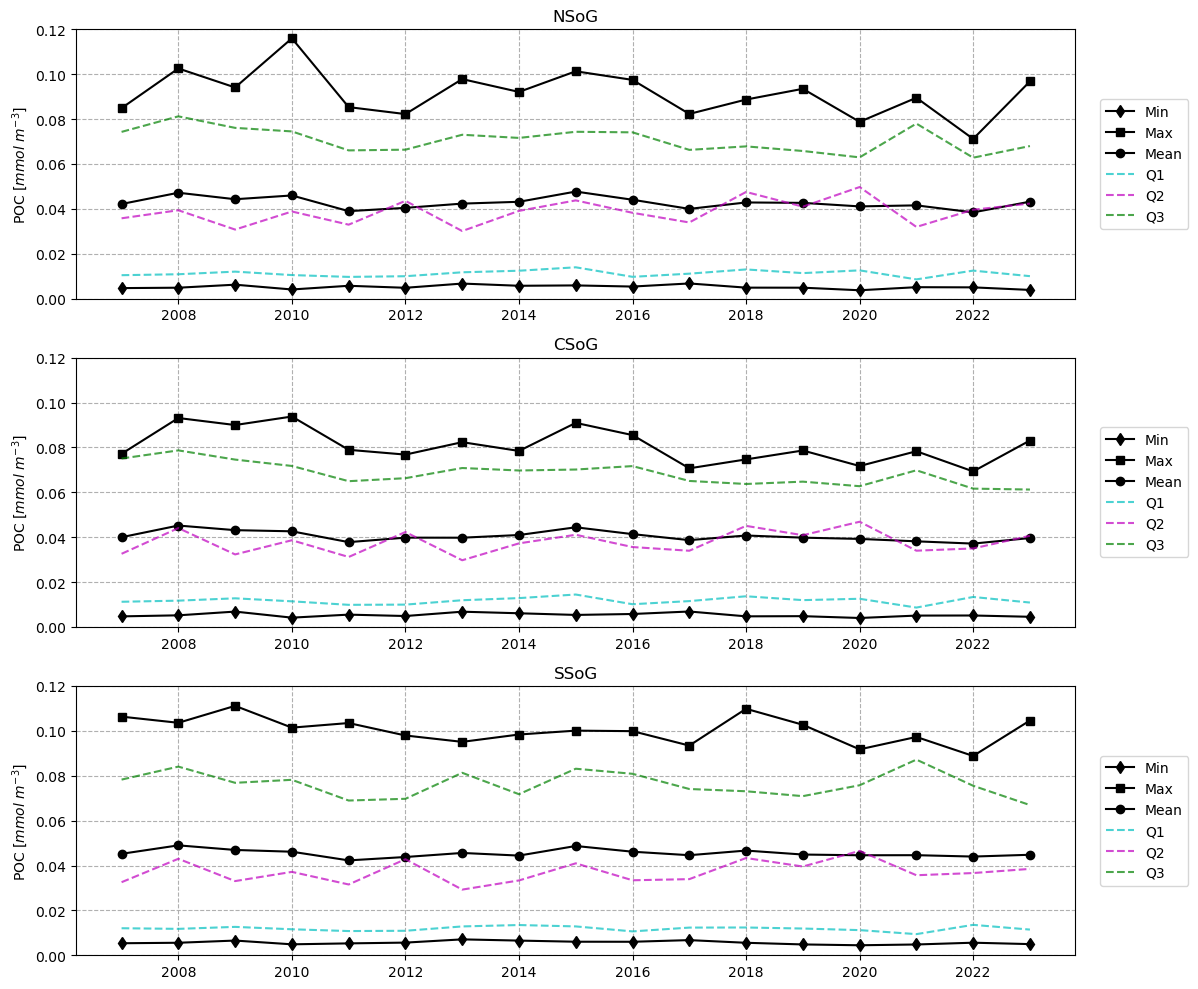

In [53]:
fig, ax = plt.subplots(3,1, figsize=(12,10))
ax[0].plot(POC_NSoG_all.columns, min_poc_NSoG, '-dk', label = 'Min')
ax[0].plot(POC_NSoG_all.columns, max_poc_NSoG, '-sk', label = 'Max')
ax[0].plot(POC_SSoG_all.columns, mean_poc_NSoG, '-ok', label = 'Mean')
ax[0].plot(POC_NSoG_all.columns, quartiles_POC_NSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[0].plot(POC_NSoG_all.columns, quartiles_POC_NSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[0].plot(POC_NSoG_all.columns, quartiles_POC_NSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[0].grid(linestyle = '--')
ax[0].set_title('NSoG')
ax[0].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[0].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[0].set_ylim(0, 0.12)
#
#
ax[1].plot(POC_NSoG_all.columns, min_poc_CSoG, '-dk', label = 'Min')
ax[1].plot(POC_NSoG_all.columns, max_poc_CSoG, '-sk', label = 'Max')
ax[1].plot(POC_SSoG_all.columns, mean_poc_CSoG, '-ok', label = 'Mean')
ax[1].plot(POC_NSoG_all.columns, quartiles_POC_CSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[1].plot(POC_NSoG_all.columns, quartiles_POC_CSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[1].plot(POC_NSoG_all.columns, quartiles_POC_CSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[1].grid(linestyle = '--')
ax[1].set_title('CSoG')
ax[1].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[1].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[1].set_ylim(0, 0.12)
#
#
ax[2].plot(POC_NSoG_all.columns, min_poc_SSoG, '-dk', label = 'Min')
ax[2].plot(POC_NSoG_all.columns, max_poc_SSoG, '-sk', label = 'Max')
ax[2].plot(POC_SSoG_all.columns, mean_poc_SSoG, '-ok', label = 'Mean')
ax[2].plot(POC_NSoG_all.columns, quartiles_POC_SSoG.iloc[0], '--c', alpha = 0.7, label = 'Q1')
ax[2].plot(POC_NSoG_all.columns, quartiles_POC_SSoG.iloc[1], '--m', alpha = 0.7, label = 'Q2')
ax[2].plot(POC_NSoG_all.columns, quartiles_POC_SSoG.iloc[2], '--g', alpha = 0.7, label = 'Q3')
ax[2].grid(linestyle = '--')
ax[2].set_title('SSoG')
ax[2].legend(loc = 'right', bbox_to_anchor=(1.12, 0.5))
ax[2].set_ylabel(r'POC [$mmol\ m^{-3}$]')
ax[2].set_ylim(0, 0.12)
#
#
plt.tight_layout()

$$\textbf{POC comparison between model POC and POC observations}$$

In [57]:
path['bat']

'/ocean/vvalenzuela/MOAD/grid/bathymetry_202108.nc'

In [58]:
bathy = xr.open_dataset(path['bat'])
model_lat = bathy.nav_lat.values
model_lon = bathy.nav_lon.values

Sun et al. (2023) stations locations and names

In [124]:
stations = ['JF2', 'HS', 'S4-1.5', 'S2', 'NG', 'S1', 'S3', 'FR']
lat = np.array([48 + (18/60), 48 + (37.80/60) , 49 + (15/60) , 49 + (17.58/60) , 49 + (43.60/60), 49 + (12.32/60), 49 + (17.88/60), 49 + (08.66/60)])
lon = (-1) * np.array([124, 123 + (14.60/60), 123 + (40/60), 123 + (22.51/60), 124 + (40.80/60), 123 + (18/60), 123 + (04.91/60), 123 + (02.65/60)]) 

Stations sampling dates amd depths

In [165]:
# for S4-1.5 ---> Southern Strait
time_SS = [datetime(2017,5,9), datetime(2017,5,9), datetime(2017,9,15) ,datetime(2017,9,15) ,datetime(2018,1,25) ,datetime(2018,1,25) ,datetime(2018,4,12) ,datetime(2018,4,17), datetime(2018,8,10), datetime(2018,8,7)]
depth_SS = np.array([25, 150, 25, 150, 25, 150, 25, 150, 25, 150])
poc_SS_f = np.array([67.5, 45, 19, 19.5, 13.6, 15.6, 35.5, 25.8, 86.3, 25.4]) * (10**(-9)) # Conversion to KG/L
poc_SS_L = np.array([23.3, 2.1, 0.7, 1.3, 0.8, 0.4, 6.9, 1.5, 3.5, 0.4]) * (10**(-9)) # Conversion to KG/L
lat_SS = np.array([49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60), 49 + (15/60)])
lon_SS = (-1) * np.array([123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60), 123 + (40/60)])

#
# for NG ---> Northern Strait
time_NS = [datetime(2018,8,25), datetime(2018,8,24)]
depth_NS = np.array([25, 150])
poc_NS_f = np.array([21.7, 19.4]) * (10**(-9)) # Conversion to KG/L
poc_NS_L = np.array([0.9, 0.6]) * (10**(-9)) # Conversion to KG/L
lat_NS = np.array([49 + (43.60/60), 49 + (43.60/60)])
lon_NS = (-1) * np.array([124 + (40.80/60), 124 + (40.80/60)])

In [142]:
folder = make_prefix(datetime(2023, 1, 1),path['NEMO'],res='d')+'_biol_T.nc'

In [144]:
poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(16/106)

In [108]:
path_grid = '/ocean/vvalenzuela/MOAD/grid/grid_from_lat_lon_mask999.nc'
grid = xr.open_dataset(path_grid)

In [230]:
grid_Y_SS = np.zeros(len(lat_SS)).astype(int)
grid_X_SS = np.zeros_like(grid_Y_SS)
poc_model_SS = []
gp_SS_i =[]
gp_SS_j =[]
for i in range(0,len(poc_SS_f)):
    folder = make_prefix(time_SS[i],path['NEMO'],res='d')+'_biol_T.nc'
    poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(16/106)
    #
    grid_Y_SS = grid.jj.sel(lats=lat_SS[i], lons=lon_SS[i], method='nearest').item()
    grid_X_SS = grid.ii.sel(lats=lat_SS[i], lons=lon_SS[i], method='nearest').item()
    gp_SS_i.append(grid_X_SS)
    gp_SS_j.append(grid_Y_SS)
    poc_model_SS.append((poc.sel(deptht = depth_SS[i], x = grid_X_SS, y = grid_Y_SS, method = 'nearest')).values)
poc_model_SS = np.array(poc_model_SS)*(12*10**(-3)) # Conversion to KG/L
#################################################################################################################
grid_Y_NS = np.zeros(len(lat_NS)).astype(int)
grid_X_NS = np.zeros_like(grid_Y_NS)
poc_model_NS = []
gp_NS_i =[]
gp_NS_j =[]
for i in range(0,len(poc_NS_f)):
    folder = make_prefix(time_NS[i],path['NEMO'],res='d')+'_biol_T.nc'
    poc = xr.open_dataset(folder)['particulate_organic_nitrogen']*(16/106)
    #
    grid_Y_NS = grid.jj.sel(lats=lat_NS[i], lons=lon_NS[i], method='nearest').item()
    grid_X_NS = grid.ii.sel(lats=lat_NS[i], lons=lon_NS[i], method='nearest').item()
    gp_NS_i.append(grid_X_NS)
    gp_NS_j.append(grid_Y_NS)    
    poc_model_NS.append((poc.sel(deptht = depth_NS[i], x = grid_X_NS, y = grid_Y_NS, method = 'nearest')).values)
poc_model_NS = np.array(poc_model_NS)*(12*10**(-3)) # Conversion to KG/L    

In [253]:
dd_s = depth_SS.astype(str).tolist()
dd_n = depth_NS.astype(str).tolist()
bathy = xr.open_dataset(path['bat'])

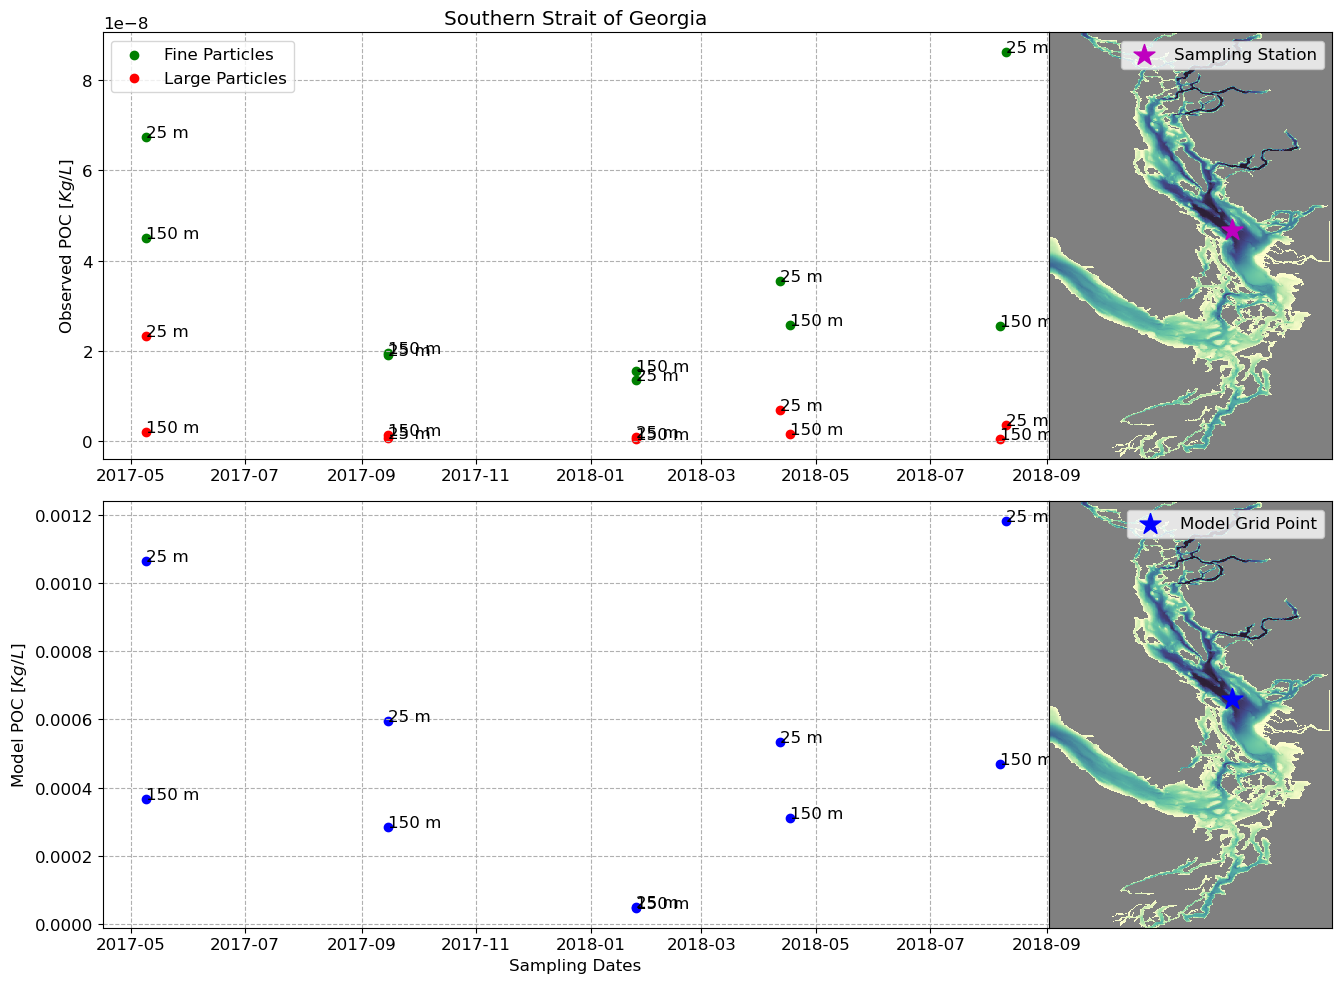

In [254]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(2,1, figsize=(14,10))
    #
    ax[0].scatter(time_SS, poc_SS_f, c = 'g', label = 'Fine Particles')
    ax[0].scatter(time_SS, poc_SS_L, c = 'r', label = 'Large Particles')
    #
    for i, txt in enumerate(dd_s):
        ax[0].annotate(txt+' m', (time_SS[i], poc_SS_f[i]))
        ax[0].annotate(txt+' m', (time_SS[i], poc_SS_L[i])) 
    #
    ax[0].grid(linestyle = '--')
    ax[0].set_ylabel(r'Observed POC [$Kg/L$]')
    ax[0].legend()
    ax[0].set_title('Southern Strait of Georgia')
    #
    axins = ax[0].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_SS_i[0],gp_SS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    #
    # 
    ax[1].scatter(time_SS, poc_model_SS, c = 'b')
    for i, txt in enumerate(dd):
        ax[1].annotate(txt+' m', (time_SS[i], poc_model_SS[i])) 
    #
    ax[1].grid(linestyle = '--') 
    #
    ax[1].set_xlabel('Sampling Dates')
    ax[1].set_ylabel(r'Model POC [$Kg/L$]')
    #
    axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins1.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins1.scatter(gp_SS_i[0],gp_SS_j[0], c ='b', marker='*', s=250, label = 'Model Grid Point')
    axins1.legend()
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()
plt.show()       

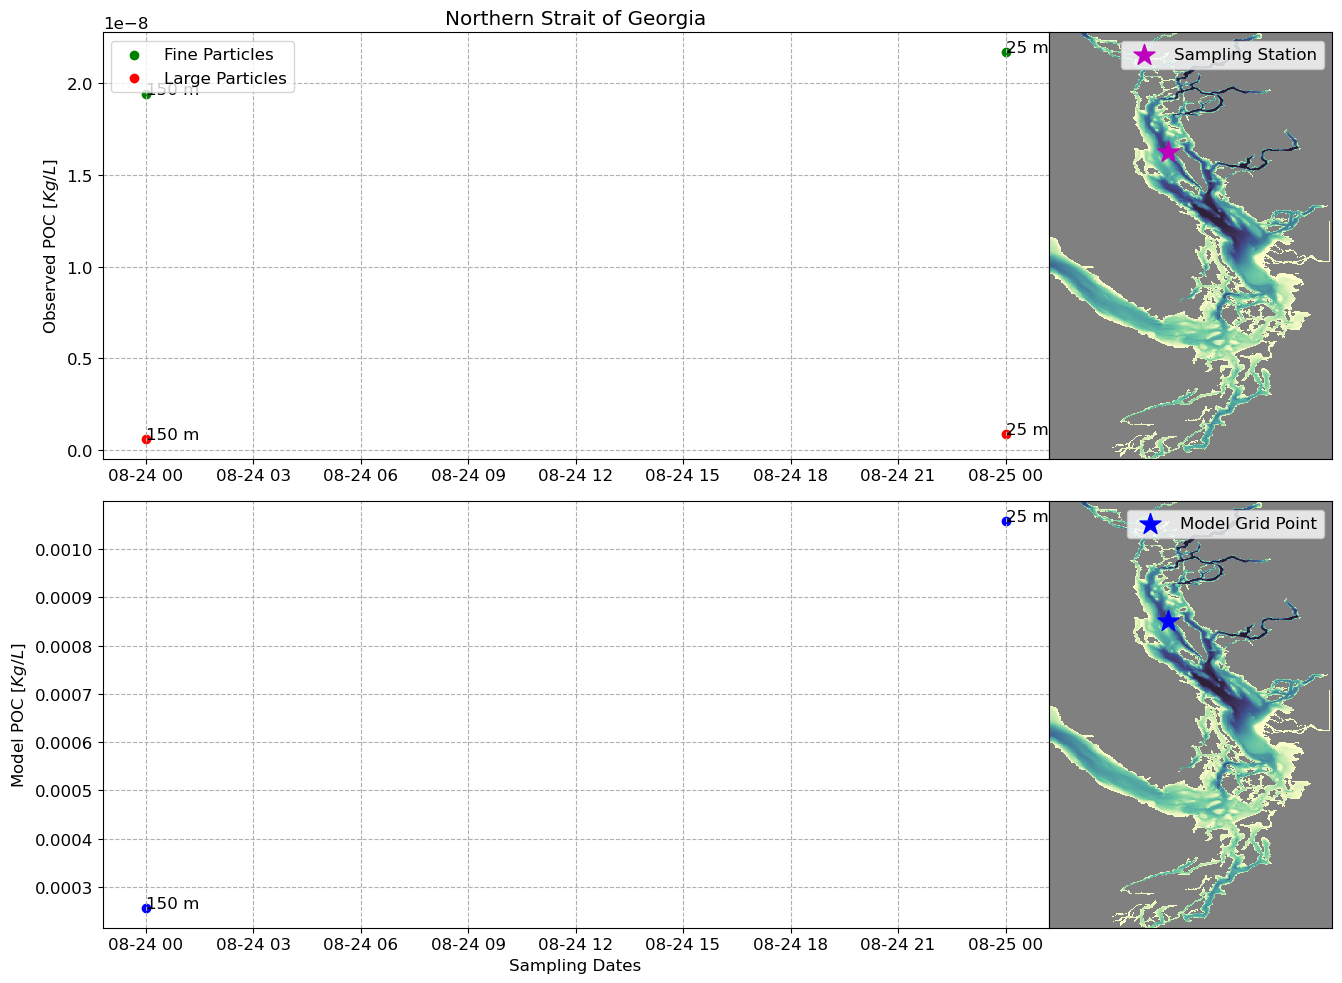

In [259]:
with plt.rc_context({'font.size': 12}):
    fig, ax = plt.subplots(2,1,figsize=(14,10))
    #
    ax[0].scatter(time_NS, poc_NS_f, c = 'g', label = 'Fine Particles')
    ax[0].scatter(time_NS, poc_NS_L, c = 'r', label = 'Large Particles')
    #
    for i, txt in enumerate(dd_n):
        ax[0].annotate(txt+' m', (time_NS[i], poc_NS_f[i]))
        ax[0].annotate(txt+' m', (time_NS[i], poc_NS_L[i])) 
    #
    ax[0].grid(linestyle = '--')
    ax[0].set_ylabel(r'Observed POC [$Kg/L$]')
    ax[0].legend()
    ax[0].set_title('Northern Strait of Georgia')
    #
    axins = ax[0].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins.scatter(gp_NS_i[0],gp_NS_j[0], c ='m', marker='*', s=250, label = 'Sampling Station')
    axins.legend()
    #
    axins.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    ####################################################################################################################
    ax[1].scatter(time_NS, poc_model_NS, c = 'b')
    for i, txt in enumerate(dd_n):
        ax[1].annotate(txt+' m', (time_NS[i], poc_model_NS[i])) 
    #
    ax[1].grid(linestyle = '--') 
    #
    ax[1].set_xlabel('Sampling Dates')
    ax[1].set_ylabel(r'Model POC [$Kg/L$]')
    #
    axins1 = ax[1].inset_axes([1, 0, 0.3, 1])
    #
    prof = axins1.pcolormesh(bathy.Bathymetry, cmap=cmap)
    axins1.scatter(gp_NS_i[0],gp_NS_j[0], c ='b', marker='*', s=250, label = 'Model Grid Point')
    axins1.legend()
    axins1.tick_params(which='both',bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    #
    #
    plt.tight_layout()